# **DIDN data preparation**

The data is prepared taking the reference of paper: 

```
@inproceedings{yu2019deep,
  title={Deep iterative down-up CNN for image denoising},
  author={Yu, Songhyun and Park, Bumjun and Jeong, Jechang},
  booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops},
  year={2019}

and 

  @article{zhang2017beyond,
    title={Beyond a {Gaussian} denoiser: Residual learning of deep {CNN} for image denoising},
    author={Zhang, Kai and Zuo, Wangmeng and Chen, Yunjin and Meng, Deyu and Zhang, Lei},
    journal={IEEE Transactions on Image Processing},
    year={2017},
    volume={26}, 
    number={7}, 
    pages={3142-3155}, 
  }
```
And, the implementation is based on the reference of: [https://github.com/SonghyunYu/DIDN/blob/master/color_dataset.py](https://github.com/SonghyunYu/DIDN/blob/master/color_dataset.py)



*   Though, the output of this file is not entirely implemented during the training of architecture due to computing power constraints (trained on Google Colab). However, it visualizes the idea behind the data preparation.

*   For both **DIDN & DnCNN**, data is prepared in same way. Only difference is the patch size and stride to form the patches.

*   The output shown in this file is for DIDN.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Patch Generation

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import random

# Stride and patches are taken with the reference of official code implemented
patch_size = 64
stride = 64

def gen_patch(img_list):
    Train_patch = []
    Noiseimg_patch = []
    n = len(img_list)
    print(n)
    for i in range(n):
        img = cv2.imread(img_list[i])
        for p in range(0, img.shape[0] - patch_size+1, stride):
            for q in range(0, img.shape[1] - patch_size+1, stride):
                height_slice = slice(p, p+patch_size)
                width_slice = slice(q, q+patch_size)
                patch = img[height_slice, width_slice, :]
                sigma = random.randint(5, 50)
                AWG_noise = np.random.normal(0.0, sigma/255, patch.shape)
                Noisy_patch = patch/255+AWG_noise
                Train_patch.append(patch/255) #keeping data between [0-1]
                Noiseimg_patch.append(Noisy_patch)          
                
    return np.array(Train_patch), np.array(Noiseimg_patch)  

## Getting Training and Validation Patches

In [ ]:
train_path = '/content/drive/My Drive/BSR_bsds500/BSR/BSDS500/data/images/train'
train_file_list = glob.glob(train_path+'/*.jpg')

val_path = '/content/drive/My Drive/BSR_bsds500/BSR/BSDS500/data/images/val'
val_file_list = glob.glob(val_path+'/*.jpg')            
        
Train_Label, Train_Data = gen_patch(train_file_list)
Val_Label, Val_Data = gen_patch(val_file_list)

200
100


### Visualizations

Visualizing the patches which are formed to get clear idea behind the formed patches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


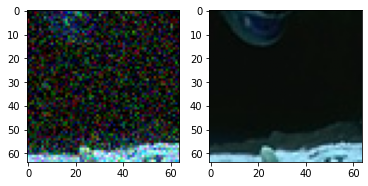

In [ ]:
f, axarr = plt.subplots(1,2)
i = 800
axarr[0].imshow(Val_Data[i]) # Noisy formed patch
axarr[1].imshow(Val_Label[i]) # Patch extracted from the validation set of BSD500 

Checking the max value of the image for using the correct form of PSNR formula in later period

In [ ]:
import numpy as np
img = Val_Label[i]
max_channels = np.amax([np.amax(img[:,:,0]), np.amax(img[:,:,1]), np.amax(img[:,:,2])])
print(max_channels)

1.0


In [ ]:
filename = '/content/drive/My Drive/BSR_bsds500/BSR/DIDN_valdata.npz'
savez_compressed(filename, Val_Data, Val_Label)
print('Saved dataset: ', filename)

Saved dataset:  /content/drive/My Drive/BSR_bsds500/BSR/DIDN_valdata.npz


## Data Augmentation

In [ ]:
from numpy.random import randint
ix = randint(0, len(Train_Data), len(Train_Label))
print(ix)
X1_noise, X2_clean = Train_Data[ix], Train_Label[ix]  #Shuffling the data patches
X1_noise[3].shape

[5880  633 1876 ... 3381 6697 1708]


(64, 64, 3)

This augmentation is done based on the details given in the paper. (*i.e.* Random rotation and flipping)

In [ ]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from numpy import asarray

rt = randint(10,35,1) #random rotation
print(rt)
src_list_train, tar_list_train = [], []

for i in range(Train_Data.shape[0]):
    src_list_train.append(X1_noise[i])
    tar_list_train.append(X2_clean[i])
    
    #Data augmentation
    
    #rotating
    rotate1 = iaa.Affine(rotate=rt)
    src_list_train.append(rotate1.augment_image(X1_noise[i]))
    tar_list_train.append(rotate1.augment_image(X2_clean[i]))     
    
    #flip verticle
    flip_vr=iaa.Flipud(p=1.0)
    src_list_train.append(flip_vr.augment_image(X1_noise[i]))
    tar_list_train.append(flip_vr.augment_image(X2_clean[i]))
    
    
Train_data_patch = np.array(src_list_train)
Train_label_patch = np.array(tar_list_train)
print(Train_data_patch[1].shape)


[26]
(64, 64, 3)


Saving the data to use for training but could not be used in our case due to CPU RAM limit in google colab.

In [ ]:
from numpy import savez_compressed
filename = '/content/drive/My Drive/BSR_bsds500/BSR/DIDN_traindata.npz'
savez_compressed(filename, Train_data_patch, Train_label_patch)
print('Saved dataset: ', filename)

Saved dataset:  /content/drive/My Drive/BSR_bsds500/BSR/DIDN_traindata.npz
